# 1. Reading the kmers used to build the RandomForest in order to build an SVM model using these kmers only.

In [3]:
import pandas as pd
import os

os.chdir('..')

# Reading .csv file containing only the kmers used to build the RandomForest
selected_kmers=pd.read_csv('Data/Matrices/ImportantKmers.csv', usecols = ['Kmer', 'Importance'],index_col=0)

print(selected_kmers.head())
print(selected_kmers.shape)
print(selected_kmers.dtypes)

                                 Importance
Kmer                                       
ACCAGTACCACCTGCCAAAGAAGAACCTAAA    0.009313
ACAGCGATTCAGACTCAGATAGCGACTCAGA    0.007401
TAACCAAGACGGAAAACGACCAACTGAAATC    0.006464
AATTCAACTAAGTTAGACTCAGTAGTAACCT    0.006102
AGTCGGAATCACTATCTGAATCCGAATCACT    0.004921
(1364, 1)
Importance    float64
dtype: object


# 2. Investigating which of the 12 genes the selected kmers origninated from

### 2.1 Creating a dictionary with keys = genes that the selected kmers originated from & value = the number of kmers from the 1365 selected kmers that originated from that gene.

In [4]:
import os
import operator

gene_files=[file for file in os.listdir('Data/Genes/') if '.fasta' in file]

gene_prevalence={} # keys = gene name, value = number of selected kmers that originated from this gene

for kmer in selected_kmers.index:
    for file in gene_files:
        gene = open(file,'r')
        gene_name = file[:file.find('.fasta')]
        gene_seq=gene.readlines()
        gene_seq.pop(0)
        for line in gene_seq:
            line=line.rstrip().upper()
            if line.find(kmer) != -1:
                Flag = False
                # print(kmer,line.find(kmer))
                if gene_name not in gene_prevalence.keys():
                    gene_prevalence[gene_name] = 1
                else:
                    gene_prevalence[gene_name] += 1

gene_prevalence = dict(sorted(gene_prevalence.items(), key=operator.itemgetter(1)))
print(gene_prevalence)

{'eno': 2, 'ebps': 5, 'clfA': 54, 'fnbB': 105, 'clfB': 123, 'fnbA': 144, 'cna': 314}
{'eno': 0.0007423868373452, 'ebps': 0.0015724935737904471, 'clfA': 0.03359316640572847, 'fnbB': 0.060393131056015195, 'fnbA': 0.09667788323601248, 'clfB': 0.10519333848693638, 'cna': 0.29717905575676623}


### 2.2 Plotting bar plot to show which genes the selected kmers originated from and the number of kmers from each gene.

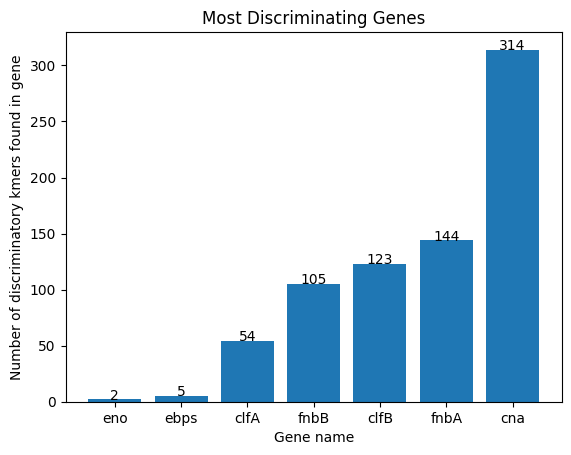

In [5]:
import matplotlib.pyplot as plt

plt.bar(range(len(gene_prevalence)), gene_prevalence.values(), tick_label=list(gene_prevalence.keys()))
for i in range(len(gene_prevalence.keys())):
        plt.text(i, list(gene_prevalence.values())[i], list(gene_prevalence.values())[i], ha = 'center')

plt.title('Most Discriminating Genes')
plt.xlabel('Gene name')
plt.ylabel('Number of discriminatory kmers found in gene')
plt.show()



# 3. Creating a new kmer presence/absence matrix of only the kmers used to build the RandomForest model. This will be done by selecting the columns that correspond to these specific kmers from the original full-sized dataframe.and saving them in a new reduced dataframe.
This will results in a reduction of the matrix size from (120, 22435) to (120, 1365).

In [6]:
import os
import pandas as pd

# Reading the original full-sized kmer presence/absence matrix
df = pd.read_csv('Data/Matrices/FullGeneKmerMatrix.csv', index_col=0)

# Checking that dataframe was read correctly
print(df.head())

c:\Users\HP\Desktop\python_notebooks\RF\genes
c:\Users\HP\Desktop\python_notebooks
        AAAACAACGCTAATCAAGCGAACAATCAAGC  AAACAACGCTAATCAAGCGAACAATCAAGCA  \
CA_001                              0.0                              0.0   
CA_002                              0.0                              0.0   
CA_003                              0.0                              0.0   
CA_005                              0.0                              0.0   
CA_007                              0.0                              0.0   

        AAATTATTAAAGTTTAAAGAATAACCACCAT  AAAGATTTTTGTAGTTCTTCATCTTGGTTAA  \
CA_001                              0.0                              0.0   
CA_002                              0.0                              0.0   
CA_003                              0.0                              0.0   
CA_005                              0.0                              0.0   
CA_007                              0.0                              0.0   

   

In [7]:
# Creating a new matrix out of the selected kmers only by selecting the rows and columns of these kmers only
labels=df.loc[:,'Label']
filtered_kmer_df = df[selected_kmers.index]
filtered_kmer_df['Label'] = labels
print('New reduced dataframe head:\n', filtered_kmer_df.head())
print('Reduced dataframe dimensions:', filtered_kmer_df.shape)

        ACCAGTACCACCTGCCAAAGAAGAACCTAAA  ACAGCGATTCAGACTCAGATAGCGACTCAGA  \
CA_001                              0.0                              1.0   
CA_002                              0.0                              0.0   
CA_003                              0.0                              1.0   
CA_005                              0.0                              1.0   
CA_007                              0.0                              0.0   

        TAACCAAGACGGAAAACGACCAACTGAAATC  AATTCAACTAAGTTAGACTCAGTAGTAACCT  \
CA_001                              0.0                              0.0   
CA_002                              0.0                              0.0   
CA_003                              0.0                              0.0   
CA_005                              1.0                              0.0   
CA_007                              0.0                              0.0   

        AGTCGGAATCACTATCTGAATCCGAATCACT  AATATACAGTGACCGAAGATCACGTAAAAGA  \
CA_001    

C:\Users\HP\AppData\Local\Temp\ipykernel_1476\1131538854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_kmer_df['Label'] = labels


In [11]:
# Saving the dataframe
filtered_kmer_df.to_csv('Data/Matrices/FilteredKmerMatrix.csv', index=True)

# 2. Train/Test split with stratification

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

train_df, test_df = train_test_split(filtered_kmer_df, train_size=0.8, test_size=0.2, random_state=0, stratify=filtered_kmer_df.loc[:,'Label'])
train_labels = train_df.loc[:,'Label']
test_labels = test_df.loc[:,'Label']

print('Number of samples within each class:\t\t\t\t\t ' , np.unique(filtered_kmer_df.loc[:,'Label'], return_counts=True))
print('Number of samples within each class in training dataframe (stratified):\t ' , np.unique(train_df.loc[:,'Label'], return_counts=True))
print('Number of samples within each class in testing dataframe (stratified):\t ', np.unique(test_df.loc[:,'Label'], return_counts=True))

# Dropping the labels of both the train and test dataframes after storing them in separate series above (train_labels, test_labels)
train_df = train_df.drop(labels='Label', axis=1)
test_df = test_df.drop(labels='Label', axis=1)

Number of samples within each class:					  (array([0, 1], dtype=int64), array([28, 92], dtype=int64))
Number of samples within each class in training dataframe (stratified):	  (array([0, 1], dtype=int64), array([22, 74], dtype=int64))
Number of samples within each class in testing dataframe (stratified):	  (array([0, 1], dtype=int64), array([ 6, 18], dtype=int64))


# 3. Building Support Vector Machines classifier using default parameters to determine baseline accuracy.
**Default parameters for Linear SVM (kernel='linear'):**
- C = 1
- tol = 0.001

**Default parameters for Polynomial SVM (kernel='poly'):**
- C = 1
- tol = 0.001
- degree = 3
- gamma = 'scale'
- coef0 = 0.0

**Default parameters for RBF SVM (kernel='rbf')**
- C = 1
- tol = 0.001
- gamma = 'scale'

**Default parameter for Sigmoid SVM (kernel='sigmoid')**
- C = 1
- tol = 0.001
- gamma = 'scale'
- coef0 = 0.0

In [68]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Initializing Linear SVM classifier using default parameters as baseline
svm_estimator_linear = svm.SVC(random_state=0,  kernel='linear')
baseline_accuracy_linear = cross_val_score(svm_estimator_linear, train_df, train_labels, cv=5, scoring='accuracy')
baseline_f1_linear = cross_val_score(svm_estimator_linear, train_df, train_labels, cv=5, scoring='f1_weighted')

print('Linear SVM:\n')
print('Baseline accuracy: ')
print(baseline_accuracy_linear)
print('Mean baseline accuracy:', baseline_accuracy_linear.mean())

print('\nBaseline F1 score: ')
print(baseline_f1_linear)
print('Mean baseline F1 score:', baseline_f1_linear.mean())
print('---------------------------------------------------------------\n\n')

# Initializing Polynomial (degree = 3) SVM classifier using default parameters as baseline
svm_estimator_poly = svm.SVC(random_state=0,  kernel='poly')
baseline_accuracy_poly = cross_val_score(svm_estimator_poly, train_df, train_labels, cv=5, scoring='accuracy')
baseline_f1_poly = cross_val_score(svm_estimator_poly, train_df, train_labels, cv=5, scoring='f1_weighted')

print('Polynomial (degree = 3) SVM:\n')
print('Baseline accuracy: ')
print(baseline_accuracy_poly)
print('Mean baseline accuracy:', baseline_accuracy_poly.mean())

print('\nBaseline F1 score: ')
print(baseline_f1_poly)
print('Mean baseline F1 score:', baseline_f1_poly.mean())
print('---------------------------------------------------------------\n\n')

# Initializing RBF SVM classifier using default parameters as baseline
svm_estimator_rbf = svm.SVC(random_state=0,  kernel='rbf')
baseline_accuracy_rbf = cross_val_score(svm_estimator_rbf, train_df, train_labels, cv=5, scoring='accuracy')
baseline_f1_rbf = cross_val_score(svm_estimator_rbf, train_df, train_labels, cv=5, scoring='f1_weighted')

print('Radial Basis Function (RBF) SVM:\n')
print('Baseline accuracy: ')
print(baseline_accuracy_rbf)
print('Mean baseline accuracy:', baseline_accuracy_rbf.mean())

print('\nBaseline F1 score: ')
print(baseline_f1_rbf)
print('Mean baseline F1 score:', baseline_f1_rbf.mean())
print('---------------------------------------------------------------\n\n')

# Initializing sigmoid SVM classifier using default parameters as baseline
svm_estimator_sigmoid = svm.SVC(random_state=0,  kernel='sigmoid')
baseline_accuracy_sigmoid = cross_val_score(svm_estimator_sigmoid, train_df, train_labels, cv=5, scoring='accuracy')
baseline_f1_sigmoid = cross_val_score(svm_estimator_sigmoid, train_df, train_labels, cv=5, scoring='f1_weighted')

print('Sigmoid SVM:\n')
print('Baseline accuracy: ')
print(baseline_accuracy_sigmoid)
print('Mean baseline accuracy:', baseline_accuracy_sigmoid.mean())

print('\nBaseline F1 score: ')
print(baseline_f1_sigmoid)
print('Mean baseline F1 score:', baseline_f1_sigmoid.mean())

Linear SVM:

Baseline accuracy: 
[0.6        0.63157895 0.52631579 0.78947368 0.63157895]
Mean baseline accuracy: 0.6357894736842106

Baseline F1 score: 
[0.5625     0.64150275 0.57004049 0.78947368 0.61120543]
Mean baseline F1 score: 0.6349444699487145
---------------------------------------------------------------


Polynomial (degree = 3) SVM:

Baseline accuracy: 
[0.75       0.84210526 0.78947368 0.89473684 0.73684211]
Mean baseline accuracy: 0.8026315789473685

Baseline F1 score: 
[0.64285714 0.81591074 0.69659443 0.88048246 0.66985646]
Mean baseline F1 score: 0.7411402460351326
---------------------------------------------------------------


Radial Basis Function (RBF) SVM:

Baseline accuracy: 
[0.75       0.73684211 0.78947368 0.84210526 0.78947368]
Mean baseline accuracy: 0.781578947368421

Baseline F1 score: 
[0.64285714 0.62519936 0.69659443 0.80191388 0.69659443]
Mean baseline F1 score: 0.6926318469971721
---------------------------------------------------------------


Sig

### 4.1 Hyperparameter tuning of Linear SVM

In [69]:
# Setting grid search parameters for tuning
param_grid_linear = {
    'C': [0.001,0.01,0.1,1,10,100,1000],
    'tol': [0.001,0.0001,0.00001],

}

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing grid search to tune hyperparameters specified in param_dict
grid_search_linear = GridSearchCV(svm_estimator_linear, param_grid_linear, cv=5, scoring='accuracy', n_jobs=36)
grid_search_linear.fit(train_df, train_labels)

# Determining the best parameters
grid_results_linear_df=pd.DataFrame(grid_search_linear.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
best_params_linear_grid = grid_search_linear.best_params_
best_model_linear_grid = grid_search_linear.best_estimator_

print("\nBest parameter combination using grid search:", best_params_linear_grid)
print("\nThis combination has accuracy:\n", grid_results_linear_df[grid_results_linear_df['params'] == best_params_linear_grid])

# Determining accuracy and F1 score of the model with the most tuned hyperparameters from grid search
cv_accuracy_tuned_linear_model_grid = cross_val_score(best_model_linear_grid, train_df, train_labels, cv=5, scoring='accuracy')
cv_f1_tuned_linear_model_grid = cross_val_score(best_model_linear_grid, train_df, train_labels, cv=5, scoring='f1_weighted')

print('\nTuned Linear SVM accuracy: ')
print(cv_accuracy_tuned_linear_model_grid)
print('Mean tuned RandomForest accuracy:', cv_accuracy_tuned_linear_model_grid.mean())

print('\nTuned Linear SVM F1 score: ')
print(cv_f1_tuned_linear_model_grid)
print('Mean tuned Linear SVM F1 score:', cv_f1_tuned_linear_model_grid.mean())


Best parameter combination using grid search: {'C': 0.01, 'tol': 0.001}

This combination has accuracy:
    mean_test_score  std_test_score                     params
3         0.802632        0.035306  {'C': 0.01, 'tol': 0.001}

Tuned Linear SVM accuracy: 
[0.75       0.84210526 0.78947368 0.84210526 0.78947368]
Mean tuned RandomForest accuracy: 0.8026315789473685

Tuned Linear SVM F1 score: 
[0.64285714 0.81591074 0.69659443 0.80191388 0.69659443]
Mean tuned Linear SVM F1 score: 0.7307741235095675


### 4.2 Hyperparameter tuning of Non-Linear SVM (Polynomial, RBF, Sigmoid)

In [9]:
# Setting grid search parameters for tuning
param_grid_nonlinear1 = {
    'C': [0.0001,0.001,0.01,0.1,1,10,100,1000],
    'tol': [0.001,0.0001,0.00001],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'degree':range(3,7,1),
    'gamma': ['scale','auto'],
}

In [10]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing grid search to tune hyperparameters specified in param_dict
grid_search_nonlinear1 = GridSearchCV(svm.SVC(random_state=0), param_grid_nonlinear1, cv=5, scoring='accuracy', n_jobs=36, verbose=3)
grid_search_nonlinear1.fit(train_df, train_labels)

# Determining the best parameters
grid_results_nonlinear1_df=pd.DataFrame(grid_search_nonlinear1.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
best_params_nonlinear1_grid = grid_search_nonlinear1.best_params_
best_model_nonlinear1_grid = grid_search_nonlinear1.best_estimator_

print("\nBest parameter combination using grid search:", best_params_nonlinear1_grid)
print("\nThis combination has accuracy:\n", grid_results_nonlinear1_df[grid_results_nonlinear1_df['params'] == best_params_nonlinear1_grid])

# Determining accuracy and F1 score of the model with the most tuned hyperparameters from grid search
cv_accuracy_tuned_nonlinear1_model_grid = cross_val_score(best_model_nonlinear1_grid, train_df, train_labels, cv=5, scoring='accuracy')
cv_f1_tuned_nonlinear1_model_grid = cross_val_score(best_model_nonlinear1_grid, train_df, train_labels, cv=5, scoring='f1_weighted')
cv_roc_auc_tuned_nonlinear1_model_grid = cross_val_score(best_model_nonlinear1_grid, train_df, train_labels, cv=5, scoring='roc_auc')

print('\nTuned Nonlinear SVM accuracy: ')
print(cv_accuracy_tuned_nonlinear1_model_grid)
print('Mean tuned Nonlinear SVM accuracy:', cv_accuracy_tuned_nonlinear1_model_grid.mean())

print('\nTuned Nonlinear SVM F1 score: ')
print(cv_f1_tuned_nonlinear1_model_grid)
print('Mean tuned Nonlinear SVM F1 score:', cv_f1_tuned_nonlinear1_model_grid.mean())

print('\nTuned Nonlinear SVM ROC-AUC score: ')
print(cv_roc_auc_tuned_nonlinear1_model_grid)
print('Mean tuned Nonlinear SVM ROC-AUC score:', cv_roc_auc_tuned_nonlinear1_model_grid.mean())

Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Best parameter combination using grid search: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001}

This combination has accuracy:
      mean_test_score  std_test_score  \
288         0.802632        0.058844   

                                                params  
288  {'C': 1, 'degree': 3, 'gamma': 'scale', 'kerne...  

Tuned Nonlinear SVM accuracy: 
[0.75       0.84210526 0.78947368 0.89473684 0.73684211]
Mean tuned Nonlinear SVM accuracy: 0.8026315789473685

Tuned Nonlinear SVM F1 score: 
[0.64285714 0.81591074 0.69659443 0.88048246 0.66985646]
Mean tuned Nonlinear SVM F1 score: 0.7411402460351326

Tuned Nonlinear SVM ROC-AUC score: 
[0.44       0.68571429 0.38333333 0.63333333 0.23333333]
Mean tuned Nonlinear SVM ROC-AUC score: 0.4751428571428571


In [14]:
# Setting grid search parameters for tuning
param_grid_balanced = {
    'C': [0.0001,0.001,0.01,0.1,1,10,100,1000],
    'tol': [0.001,0.0001,0.00001],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'degree':range(3,7,1),
    'gamma': ['scale','auto'],
    'class_weight': ['balanced']
}

In [15]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score, GridSearchCV

# Performing grid search to tune hyperparameters specified in param_dict
grid_search_balanced = GridSearchCV(svm.SVC(random_state=0), param_grid_balanced, cv=5, scoring='accuracy', n_jobs=36, verbose=3)
grid_search_balanced.fit(train_df, train_labels)

# Determining the best parameters
grid_results_balanced_df=pd.DataFrame(grid_search_balanced.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
best_params_balanced_grid = grid_search_balanced.best_params_
best_model_balanced_grid = grid_search_balanced.best_estimator_

print("\nBest parameter combination using grid search:", best_params_balanced_grid)
print("\nThis combination has accuracy:\n", grid_results_balanced_df[grid_results_balanced_df['params'] == best_params_balanced_grid])

# Determining accuracy and F1 score of the model with the most tuned hyperparameters from grid search
cv_accuracy_tuned_balanced_model_grid = cross_val_score(best_model_balanced_grid, train_df, train_labels, cv=5, scoring='accuracy')
cv_f1_tuned_balanced_model_grid = cross_val_score(best_model_balanced_grid, train_df, train_labels, cv=5, scoring='f1_weighted')
cv_roc_auc_tuned_balanced_model_grid = cross_val_score(best_model_balanced_grid, train_df, train_labels, cv=5, scoring='roc_auc')

print('\nTuned Nonlinear SVM accuracy: ')
print(cv_accuracy_tuned_balanced_model_grid)
print('Mean tuned Nonlinear SVM accuracy:', cv_accuracy_tuned_balanced_model_grid.mean())

print('\nTuned Nonlinear SVM F1 score: ')
print(cv_f1_tuned_balanced_model_grid)
print('Mean tuned Nonlinear SVM F1 score:', cv_f1_tuned_balanced_model_grid.mean())

print('\nTuned Nonlinear SVM ROC-AUC score: ')
print(cv_roc_auc_tuned_balanced_model_grid)
print('Mean tuned Nonlinear SVM ROC-AUC score:', cv_roc_auc_tuned_balanced_model_grid.mean())


Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Best parameter combination using grid search: {'C': 0.001, 'class_weight': 'balanced', 'degree': 6, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.001}

This combination has accuracy:
      mean_test_score  std_test_score  \
126         0.771053        0.022942   

                                                params  
126  {'C': 0.001, 'class_weight': 'balanced', 'degr...  

Tuned Nonlinear SVM accuracy: 
[0.75       0.73684211 0.78947368 0.78947368 0.78947368]
Mean tuned Nonlinear SVM accuracy: 0.7710526315789474

Tuned Nonlinear SVM F1 score: 
[0.64285714 0.62519936 0.69659443 0.69659443 0.69659443]
Mean tuned Nonlinear SVM F1 score: 0.6715679573264712

Tuned Nonlinear SVM ROC-AUC score: 
[0.37333333 0.28571429 0.36666667 0.56666667 0.48333333]
Mean tuned Nonlinear SVM ROC-AUC score: 0.41514285714285715


# 5. Determining the model support vectors


In [12]:
# For nonlinear SVM without class balancing

# get indices of support vectors
print(best_model_nonlinear1_grid.support_)

# get number of support vectors for each class
print(best_model_nonlinear1_grid.n_support_)

[ 0  6  7  8  9 12 17 21 29 32 38 47 54 58 65 72 79 83 89 94 95  1  2  3
  4  5 10 11 13 14 18 19 20 24 26 27 28 33 35 36 37 42 43 44 45 46 50 51
 52 53 55 56 57 60 61 63 64 66 67 68 69 70 71 73 74 76 77 78 81 82 84 86
 87 88 90 91 93]
[21 56]


In [13]:
# For balanced

# get indices of support vectors
print(best_model_balanced_grid.support_)

# get number of support vectors for each class
print(best_model_balanced_grid.n_support_)


NameError: name 'best_model_balanced_grid' is not defined

# 6. Using the Optimized SVM model on testing data to determine accuracy. This process is done once for nonlinear SVM model without class balancing and again for nonlinear SVM with class balancing.
- Classification report
- Confusion matrix


In [16]:
# For nonlinear SVM without class balancing

from sklearn.metrics import classification_report

SVM_nonlinear_model_predictions = best_model_nonlinear1_grid.predict(test_df) 
  
print(classification_report(test_labels, SVM_nonlinear_model_predictions))


              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.78      1.00      0.88        18

    accuracy                           0.79        24
   macro avg       0.89      0.58      0.58        24
weighted avg       0.84      0.79      0.73        24



In [19]:
# For nonlinear SVM with class balancing

from sklearn.metrics import classification_report

SVM_nonlinear_model_predictions = best_model_balanced_grid.predict(test_df) 
  
print(classification_report(test_labels, SVM_nonlinear_model_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      1.00      0.86        18

    accuracy                           0.75        24
   macro avg       0.38      0.50      0.43        24
weighted avg       0.56      0.75      0.64        24



c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

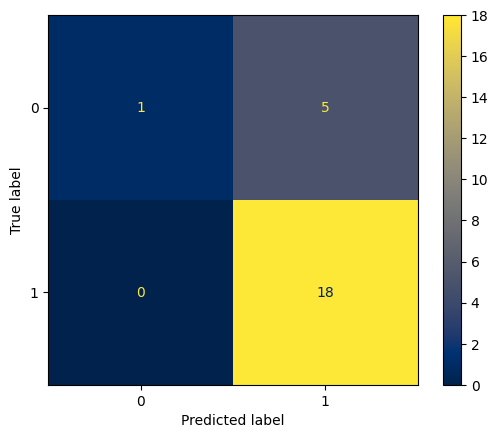

In [18]:
# For nonlinear SVM without class balancing

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SVM_nonlinear_model_predictions = best_model_nonlinear1_grid.predict(test_df) 

disp = ConfusionMatrixDisplay.from_predictions(test_labels, SVM_nonlinear_model_predictions, labels=best_model_nonlinear1_grid.classes_, cmap='cividis')


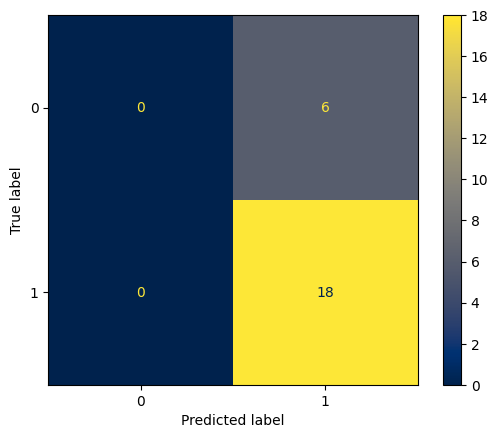

In [20]:
# For nonlinear SVM with class balancing

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SVM_nonlinear_model_predictions = best_model_balanced_grid.predict(test_df) 

disp = ConfusionMatrixDisplay.from_predictions(test_labels, SVM_nonlinear_model_predictions, labels=best_model_balanced_grid.classes_, cmap='cividis')
